In [139]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

import xgboost as xgb
import statsmodels.api as sm

# For 2nd model
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

# Importing H2O
import time, warnings, h2o, logging, os, sys, psutil, random
from h2o.automl import H2OAutoML

from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
# from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

In [6]:
# get homesite & test csv files as a DataFrame
# homesite_df = pd.read_csv("C://Users//kaila//OneDrive//Desktop//DSMT//Assignment_3_KaggleCompetition//homesite-quote-conversion//train.csv")
# test_df     = pd.read_csv("C://Users//kaila//OneDrive//Desktop//DSMT//Assignment_3_KaggleCompetition//homesite-quote-conversion//test.csv")

homesite_df = pd.read_csv("train.csv")
test_df     = pd.read_csv("test.csv")

# preview the data
homesite_df.head()

QuoteNumber Original_Quote_Date  QuoteConversion_Flag Field6  Field7  \
0            1          2013-08-16                     0      B      23   
1            2          2014-04-22                     0      F       7   
2            4          2014-08-25                     0      F       7   
3            6          2013-04-15                     0      J      10   
4            8          2014-01-25                     0      E      23   

   Field8  Field9 Field10  Field11 Field12        ...          \
0  0.9403  0.0006     965   1.0200       N        ...           
1  1.0006  0.0040     548   1.2433       N        ...           
2  1.0006  0.0040     548   1.2433       N        ...           
3  0.9769  0.0004   1,165   1.2665       N        ...           
4  0.9472  0.0006   1,487   1.3045       N        ...           

   GeographicField59A  GeographicField59B  GeographicField60A  \
0                   9                   9                  -1   
1                  10                  10                  -1   
2                  15                  18                  -1   
3                   6                   5                  -1   
4                  18                  22                  -1   

   GeographicField60B  GeographicField61A  GeographicField61B  \
0                   8                  -1                  18   
1                  11                  -1                  17   
2                  21                  -1                  11   
3                  10                  -1                   9   
4                  10                  -1                  11   

   GeographicField62A  GeographicField62B  GeographicField63  \
0                  -1                  10                  N   
1                  -1                  20                  N   
2                  -1                   8                  N   
3                  -1                  21                  N   
4                  -1                  12                  N   

   GeographicField64  
0                 CA  
1                 NJ  
2                 NJ  
3                 TX  
4                 IL  

[5 rows x 299 columns]

In [7]:
homesite_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Columns: 299 entries, QuoteNumber to GeographicField64
dtypes: float64(6), int64(265), object(28)
memory usage: 594.8+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173836 entries, 0 to 173835
Columns: 298 entries, QuoteNumber to GeographicField64
dtypes: float64(6), int64(264), object(28)
memory usage: 395.2+ MB


In [8]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
homesite_df = homesite_df.drop(['QuoteNumber'], axis=1)

In [9]:
# date

# Convert Date to Year, Month, and Week
homesite_df['Year']  = homesite_df['Original_Quote_Date'].apply(lambda x: int(str(x)[:4]))
homesite_df['Month'] = homesite_df['Original_Quote_Date'].apply(lambda x: int(str(x)[5:7]))
homesite_df['Week']  = homesite_df['Original_Quote_Date'].apply(lambda x: int(str(x)[8:10]))

test_df['Year']  = test_df['Original_Quote_Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Original_Quote_Date'].apply(lambda x: int(str(x)[5:7]))
test_df['Week']  = test_df['Original_Quote_Date'].apply(lambda x: int(str(x)[8:10]))

homesite_df.drop(['Original_Quote_Date'], axis=1,inplace=True)
test_df.drop(['Original_Quote_Date'], axis=1,inplace=True)

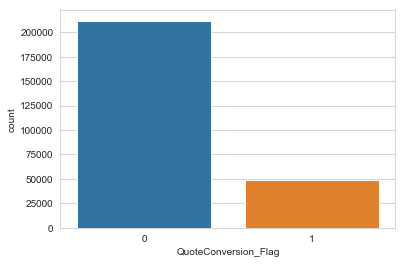

In [10]:
# customers purchased insurance plan

# Plot
sns.countplot(x="QuoteConversion_Flag", data=homesite_df)

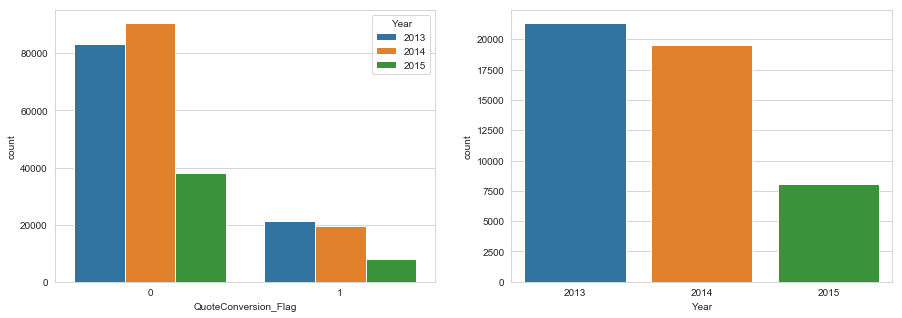

In [11]:
# year
# Which year has higher number of customers purchased insurance plan

# Plot
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x="QuoteConversion_Flag",hue="Year", data=homesite_df, ax=axis1)
sns.countplot(x=homesite_df["Year"].loc[homesite_df["QuoteConversion_Flag"] == 1], 
              order=[2013,2014,2015], ax=axis2)

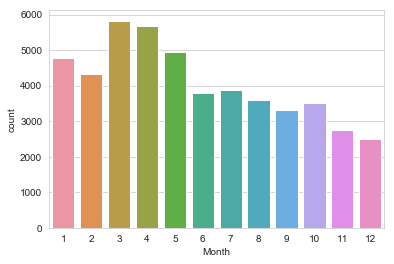

In [12]:
# month
# Which month has higher number of customers purchased insurance plan

# Plot
sns.countplot(x=homesite_df["Month"].loc[homesite_df["QuoteConversion_Flag"] == 1], 
              order=[1,2,3,4,5,6,7,8,9,10,11,12])

In [13]:
# fill NaN values
homesite_df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

In [14]:
# There are some columns with non-numerical values(i.e. dtype='object'),
# So, We will create a corresponding unique numerical value for each non-numerical value in a column of training and testing set.

from sklearn import preprocessing

for f in homesite_df.columns:
    if homesite_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(homesite_df[f].values) + list(test_df[f].values)))
        homesite_df[f] = lbl.transform(list(homesite_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

## Logistic Regression Model

In [15]:
logReg = LogisticRegression(random_state=0)

In [16]:
ylog= homesite_df["QuoteConversion_Flag"]
xlog = homesite_df.drop("QuoteConversion_Flag",axis=1)

# Xlog_test  = test_df.drop("QuoteNumber",axis=1).copy()
# Ylog_test  = test_df["QuoteConversion_Flag"]

In [17]:
Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(xlog,ylog,test_size=0.1)

In [18]:
print (Xlog_train.shape, ylog_train.shape)
print (Xlog_test.shape, ylog_test.shape)

(234677, 299) (234677,)
(26076, 299) (26076,)


In [19]:
# Predicting the test set results and creating confusion matrix
results_logistic = logReg.fit(Xlog_train, ylog_train)
print (results_logistic)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [20]:
ylog_pred = logReg.predict(Xlog_test)
ylog_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [21]:
np.array(ylog_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
# Predicting the test set results and creating confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ylog_test, ylog_pred)
print(confusion_matrix)

[[20577   666]
 [ 2092  2741]]


In [23]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logReg.score(Xlog_test, ylog_pred)))

Accuracy of logistic regression classifier on test set: 1.00


In [24]:
from sklearn.metrics import classification_report
print(classification_report(ylog_test, ylog_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     21243
           1       0.80      0.57      0.67      4833

   micro avg       0.89      0.89      0.89     26076
   macro avg       0.86      0.77      0.80     26076
weighted avg       0.89      0.89      0.89     26076



In [25]:
# summary_log = sm.Logit(ylog, xlog).fit()
# summary_log.summary()

In [26]:
logReg.predict_proba(Xlog_train)

array([[0.07190747, 0.92809253],
       [0.73134598, 0.26865402],
       [0.96991755, 0.03008245],
       ...,
       [0.82654662, 0.17345338],
       [0.99327308, 0.00672692],
       [0.94872563, 0.05127437]])

In [27]:
logReg.predict_proba(Xlog_test)

array([[0.79252438, 0.20747562],
       [0.88981427, 0.11018573],
       [0.82354218, 0.17645782],
       ...,
       [0.96449433, 0.03550567],
       [0.47151914, 0.52848086],
       [0.5347109 , 0.4652891 ]])

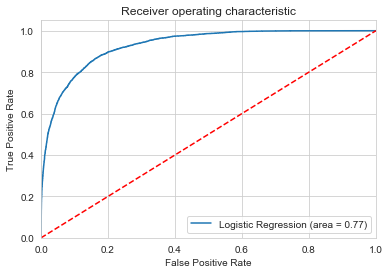

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ylog_test, logReg.predict(Xlog_test))
fpr, tpr, thresholds = roc_curve(ylog_test, logReg.predict_proba(Xlog_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## XGBoost Model

### XGB - Model 1

In [34]:
# define training and testing sets

X_train = homesite_df.drop("QuoteConversion_Flag",axis=1)
Y_train = homesite_df["QuoteConversion_Flag"]
X_test  = test_df.drop("QuoteNumber",axis=1).copy()

In [35]:
# Xgboost 

params = {"objective": "binary:logistic"}

T_train_xgb = xgb.DMatrix(X_train, Y_train)
X_test_xgb  = xgb.DMatrix(X_test)

In [49]:
Xgbm = xgb.train(params, T_train_xgb, 100)
# gbm = xgb.train(params = list(nthread = 4,
#                                       eta = 0.02,
#                                       max_depth = 4,
#                                       max_leaves = 15,
#                                       max_bin = 255,
#                                       gamma = 1,
#                                       min_child_weight = 1,
#                                       objective = "binary:logistic",
#                                       booster = "gbtree",
#                                       tree_method = "hist",
#                                       grow_policy = "lossguide"),
#                         data = T_train_xgb,
#                         watchlist = list(test = xgb_test),
#                         eval_metric = "auc",
#                         nrounds = 5,
#                         verbose = 2)

In [50]:
Y_pred = Xgbm.predict(X_test_xgb)

In [51]:
Y_pred.shape

(173836,)

In [52]:
df1=pd.DataFrame([test_df.QuoteNumber,np.array(Y_pred)])

In [53]:
df1

0         1         2         3          4          5       \
QuoteNumber  3.000000  5.000000  7.000000  9.000000  10.000000  11.000000   
Unnamed 0    0.000004  0.005815  0.000231  0.000304   0.593758   0.003676   

                   6          7             8             9       \
QuoteNumber  1.500000e+01  16.000000  1.700000e+01  2.100000e+01   
Unnamed 0    4.361788e-07   0.001133  3.649349e-07  6.987244e-11   

                 ...              173826         173827        173828  \
QuoteNumber      ...        434554.00000  434558.000000  4.345600e+05   
Unnamed 0        ...             0.04306       0.000002  7.311532e-07   

                    173829         173830         173831         173832  \
QuoteNumber  434563.000000  434565.000000  434570.000000  434573.000000   
Unnamed 0         0.999977       0.167436       0.051717       0.140305   

                    173833        173834         173835  
QuoteNumber  434574.000000  4.345750e+05  434589.000000  
Unnamed 0         0.999861  1.414172e-08       0.185701  

[2 rows x 173836 columns]

In [54]:
# df_output=df1.T
# df_output.to_csv(r'C://Users//kaila//OneDrive//Desktop//DSMT//XGBoostTest5.csv')

In [62]:
sub = pd.DataFrame(columns=['QuoteNumber','QuoteConversion_Flag'])
sub['QuoteNumber'] = test_df.QuoteNumber
sub['QuoteConversion_Flag'] = Y_pred

In [63]:
subfile = 'PredictionsL8_round.csv'
sub.to_csv(subfile,index=False)
print('Saved file: ' + subfile)

Saved file: PredictionsL8_round.csv


### XGB - Model 2

In [287]:
X_train = homesite_df
Y_train = homesite_df["QuoteConversion_Flag"]
X_test  = test_df.drop("QuoteNumber",axis=1).copy()
# Y_test  = test_df["QuoteNumber"]

target='QuoteConversion_Flag'

In [288]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
            
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['QuoteConversion_Flag'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['QuoteConversion_Flag'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['QuoteConversion_Flag'], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances',figsize=(20,12))
    plt.ylabel('Feature Importance Score')
        
    return dtrain_predictions,dtrain_predictions, cvresult, feat_imp


Model Report
Accuracy : 0.9381
AUC Score (Train): 0.976230


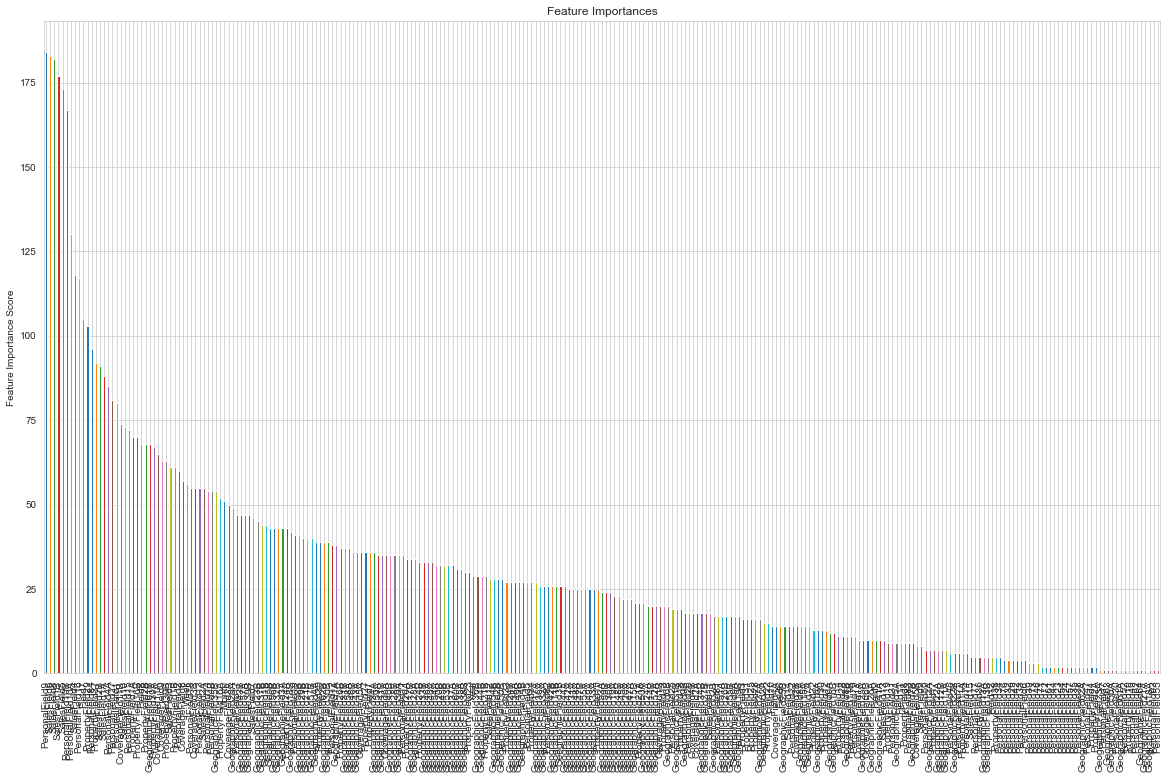

In [289]:
predictors = [x for x in X_train.columns if x not in [target]]

xgb1 = XGBClassifier(
 max_depth=5,
 learning_rate =0.1,
 n_estimators=1200,
 objective= 'binary:logistic',
 min_child_weight=1,
 gamma=10,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=11,
 scale_pos_weight=1,
# reg_alpha=L1,
 seed=27)

train_pred, train_prob, cvresult, feat_imp = modelfit(xgb1, X_train, predictors)

In [290]:
train_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [291]:
train_prob

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [292]:
cvresult

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.923951       0.000660       0.923632      0.001708
1          0.929168       0.003011       0.929004      0.003499
2          0.934844       0.004951       0.934605      0.005027
3          0.937890       0.003873       0.937713      0.004671
4          0.939643       0.003621       0.939669      0.004729
5          0.940757       0.003133       0.940804      0.004141
6          0.941301       0.002799       0.941217      0.003548
7          0.942316       0.001891       0.942355      0.002906
8          0.942935       0.002003       0.942922      0.003058
9          0.943879       0.001456       0.943772      0.002554
10         0.944868       0.001648       0.944716      0.002683
11         0.946116       0.001172       0.945945      0.002047
12         0.946901       0.000944       0.946645      0.001873
13         0.947386       0.000673       0.947141      0.001690
14         0.947453       0.000736       0.947176      0.001665
15         0.948182       0.000693       0.947904      0.001595
16         0.948522       0.000735       0.948248      0.001607
17         0.948946       0.000723       0.948692      0.001602
18         0.949214       0.000797       0.948999      0.001498
19         0.949574       0.000677       0.949269      0.001412
20         0.950223       0.000640       0.949920      0.001301
21         0.950488       0.000551       0.950177      0.001356
22         0.950883       0.000538       0.950547      0.001271
23         0.951301       0.000481       0.950945      0.001200
24         0.951774       0.000606       0.951409      0.001171
25         0.952194       0.000466       0.951832      0.001020
26         0.952562       0.000417       0.952227      0.000982
27         0.952871       0.000340       0.952550      0.001013
28         0.953333       0.000414       0.952986      0.001023
29         0.953618       0.000366       0.953263      0.001040
..              ...            ...            ...           ...
743        0.976860       0.000166       0.966151      0.000728
744        0.976867       0.000168       0.966153      0.000729
745        0.976876       0.000167       0.966153      0.000727
746        0.976890       0.000173       0.966152      0.000727
747        0.976903       0.000174       0.966153      0.000729
748        0.976917       0.000176       0.966153      0.000729
749        0.976923       0.000178       0.966154      0.000731
750        0.976928       0.000179       0.966152      0.000729
751        0.976935       0.000180       0.966152      0.000732
752        0.976940       0.000181       0.966151      0.000729
753        0.976952       0.000181       0.966150      0.000730
754        0.976960       0.000182       0.966149      0.000729
755        0.976965       0.000182       0.966150      0.000730
756        0.976970       0.000181       0.966150      0.000730
757        0.976978       0.000182       0.966149      0.000731
758        0.976988       0.000178       0.966152      0.000736
759        0.976997       0.000179       0.966153      0.000738
760        0.977003       0.000186       0.966153      0.000738
761        0.977013       0.000178       0.966156      0.000738
762        0.977018       0.000179       0.966158      0.000737
763        0.977022       0.000179       0.966161      0.000736
764        0.977030       0.000177       0.966157      0.000734
765        0.977039       0.000182       0.966157      0.000734
766        0.977049       0.000175       0.966159      0.000736
767        0.977060       0.000172       0.966162      0.000734
768        0.977065       0.000169       0.966160      0.000738
769        0.977077       0.000175       0.966161      0.000737
770        0.977084       0.000170       0.966160      0.000737
771        0.977095       0.000170       0.966162      0.000739
772        0.977105       0.000169       0.966165      0.000740

[773 rows x 4 columns]

In [293]:
feat_imp.head(50)

PersonalField9        184
SalesField6           183
SalesField8           182
SalesField1B          177
SalesField5           173
PersonalField10B      167
PersonalField10A      130
SalesField4           118
PersonalField16       117
Field7                105
PropertyField29       103
PersonalField84        96
PropertyField37        92
SalesField2B           91
SalesField1A           88
PersonalField4A        85
PersonalField27        81
PersonalField1         80
CoverageField11B       74
SalesField10           73
PersonalField15        72
PropertyField1A        70
PropertyField16B       70
Field8                 68
PropertyField2B        68
GeographicField61B     68
PropertyField39A       67
CoverageField11A       65
CoverageField9         63
PropertyField39B       63
SalesField3            61
PropertyField1B        61
PersonalField2         60
CoverageField8         57
Week                   56
PersonalField18        55
CoverageField3B        55
PersonalField13        55
SalesField2A

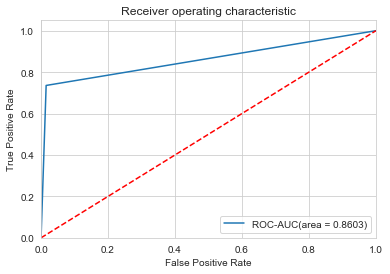

In [294]:
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(homesite_df["QuoteConversion_Flag"].values, train_pred)
fpr, tpr, thresholds = roc_curve(homesite_df["QuoteConversion_Flag"].values, train_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC-AUC(area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Test Predictions

In [295]:
dtest_predictions = xgb1.predict(X_test)

In [296]:
dtest_predictProba = xgb1.predict_proba(X_test)

In [297]:
dtest_predictProba

array([[9.9939704e-01, 6.0298166e-04],
       [9.6537012e-01, 3.4629859e-02],
       [9.7169948e-01, 2.8300550e-02],
       ...,
       [1.5884638e-03, 9.9841154e-01],
       [9.9985719e-01, 1.4279304e-04],
       [8.7675530e-01, 1.2324468e-01]], dtype=float32)

In [298]:
sub = pd.DataFrame(columns=['QuoteNumber','QuoteConversion_Flag'])
sub['QuoteNumber'] = test_df.QuoteNumber
sub['QuoteConversion_Flag'] = dtest_predictProba

In [300]:
subfile = 'PredictionsL13.csv'
sub.to_csv(subfile,index=False)
print('Saved file: ' + subfile)

Saved file: PredictionsL13.csv


### Tuning max_depth and min_child_weight

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = 
                        XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=12, scale_pos_weight=1, seed=27), 
          param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


In [ ]:
gsearch1.fit(X_train[predictors],X_train['QuoteConversion_Flag'])

In [ ]:
gsearch1.cv_results_

In [ ]:
gsearch1.best_params_

In [ ]:
gsearch1.best_score_

#### 2nd Try

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=50, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=10, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=10,iid=False, cv=5)


In [ ]:
gsearch2.fit(X_train[predictors],X_train['QuoteConversion_Flag'])

In [ ]:
gsearch2.cv_results_

In [ ]:
gsearch2.best_params_

In [ ]:
gsearch2.best_score_

### Plotting Correlation Matrix

In [50]:
X_train.corr()

QuoteConversion_Flag    Field6    Field7    Field8  \
QuoteConversion_Flag              1.000000 -0.068632 -0.137532  0.127039   
Field6                           -0.068632  1.000000 -0.326260  0.097346   
Field7                           -0.137532 -0.326260  1.000000 -0.436411   
Field8                            0.127039  0.097346 -0.436411  1.000000   
Field9                            0.179569  0.300889 -0.572369  0.710963   
Field10                           0.161776 -0.849921  0.046250  0.276233   
Field11                          -0.100376  0.846145 -0.256320  0.127229   
Field12                          -0.065667  0.233043  0.076278 -0.366945   
CoverageField1A                  -0.076398 -0.068719  0.047157 -0.018017   
CoverageField1B                  -0.070245 -0.083415  0.044923 -0.008386   
CoverageField2A                  -0.072644 -0.066890  0.045087 -0.018319   
CoverageField2B                  -0.065846 -0.081536  0.042424 -0.008816   
CoverageField3A                   0.007271 -0.086113  0.001922  0.033315   
CoverageField3B                   0.017365 -0.097927 -0.001174  0.043100   
CoverageField4A                  -0.090893 -0.009974  0.063868 -0.103657   
CoverageField4B                  -0.084327 -0.031214  0.062157 -0.089984   
CoverageField5A                   0.088120 -0.028831 -0.042595  0.083897   
CoverageField5B                   0.028350 -0.026956 -0.005215  0.069055   
CoverageField6A                  -0.064816  0.084058 -0.004488 -0.022354   
CoverageField6B                  -0.154974  0.112577  0.050475 -0.065180   
CoverageField8                    0.178042 -0.056476  0.015267 -0.133714   
CoverageField9                    0.014696  0.187774 -0.033585 -0.040279   
CoverageField11A                  0.136771  0.020370 -0.005461 -0.097156   
CoverageField11B                  0.171018  0.013119 -0.013626 -0.095915   
SalesField1A                     -0.217625  0.453671  0.105655 -0.239269   
SalesField1B                     -0.253347  0.470331  0.085459 -0.214457   
SalesField2A                     -0.175681  0.475433  0.083989 -0.230209   
SalesField2B                     -0.184501  0.536981  0.041572 -0.201369   
SalesField3                       0.108987  0.078774 -0.022992 -0.016236   
SalesField4                      -0.217373  0.065902  0.097955 -0.081396   
...                                    ...       ...       ...       ...   
GeographicField50B                0.030211  0.186329 -0.120112  0.109065   
GeographicField51A               -0.027601 -0.002640  0.001064 -0.014550   
GeographicField51B               -0.028118  0.000873 -0.000055 -0.013116   
GeographicField52A               -0.028750  0.023923 -0.007511 -0.012442   
GeographicField52B               -0.028141  0.027452 -0.011271 -0.008026   
GeographicField53A               -0.022820  0.182943 -0.055162 -0.003278   
GeographicField53B               -0.018803  0.197344 -0.070191  0.013986   
GeographicField54A                0.012943 -0.452665  0.197722 -0.086746   
GeographicField54B                0.009853 -0.470692  0.217678 -0.105721   
GeographicField55A                0.032899 -0.342821  0.113164 -0.014723   
GeographicField55B                0.029551 -0.336619  0.117692 -0.025159   
GeographicField56A               -0.001912 -0.092170  0.057585 -0.042820   
GeographicField56B               -0.027991 -0.258052  0.211673 -0.182526   
GeographicField57A               -0.007306 -0.032219  0.038254 -0.041196   
GeographicField57B               -0.008081 -0.032649  0.037996 -0.040559   
GeographicField58A               -0.001477 -0.095207  0.056158 -0.048556   
GeographicField58B               -0.001302 -0.096078  0.055686 -0.047126   
GeographicField59A                0.063788 -0.018001 -0.123446  0.173892   
GeographicField59B                0.068792 -0.013825 -0.138638  0.192334   
GeographicField60A                0.014200 -0.008149 -0.019610  0.039526   
GeographicField60B                0.012505  0.038479 -0.071154  0.0804

Plot Number:  1


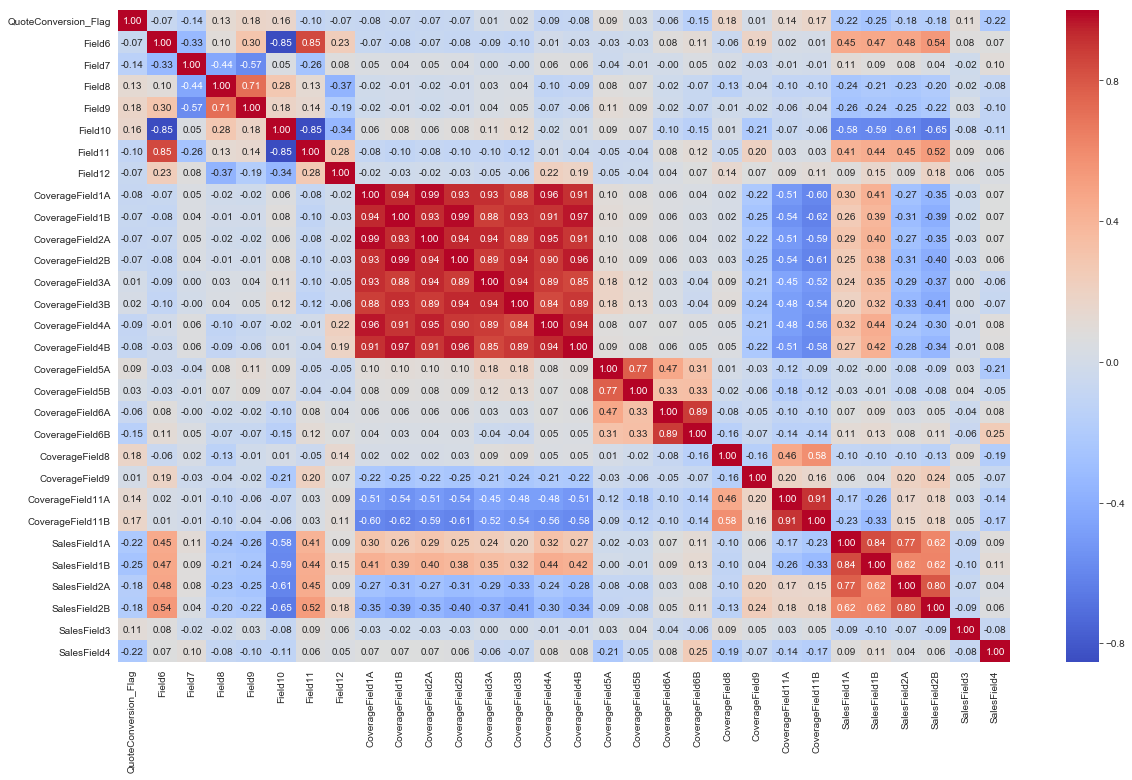

Plot Number:  2


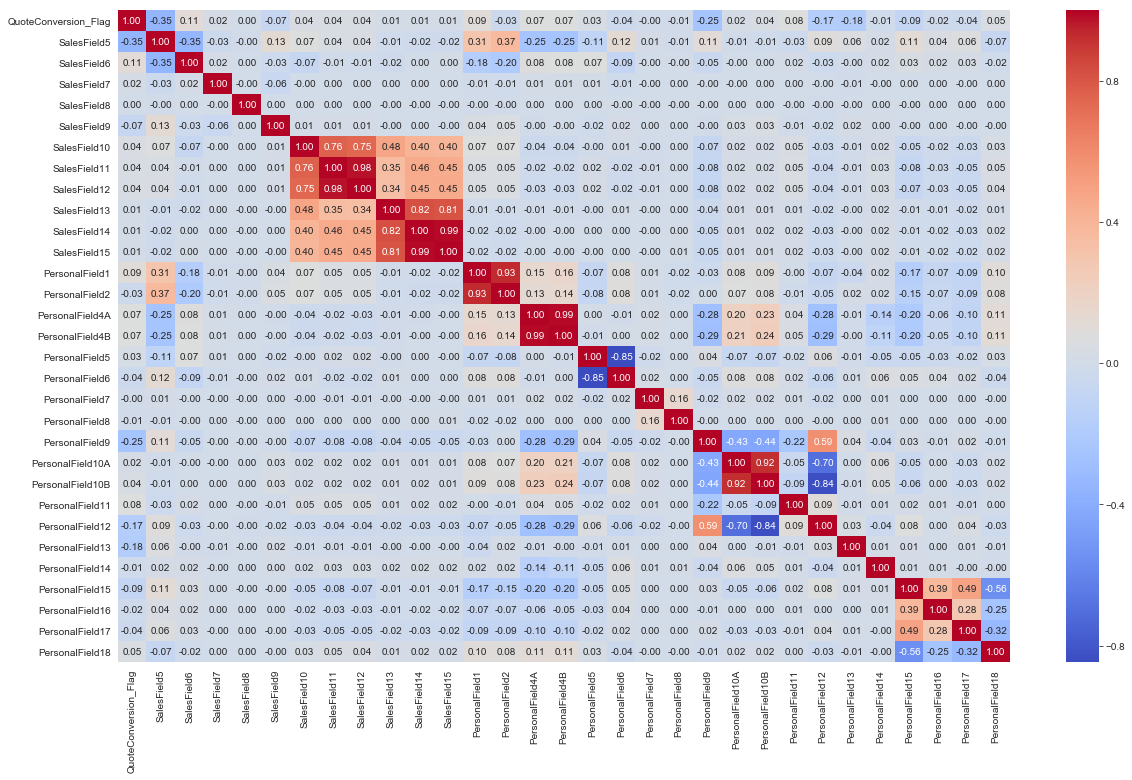

Plot Number:  3


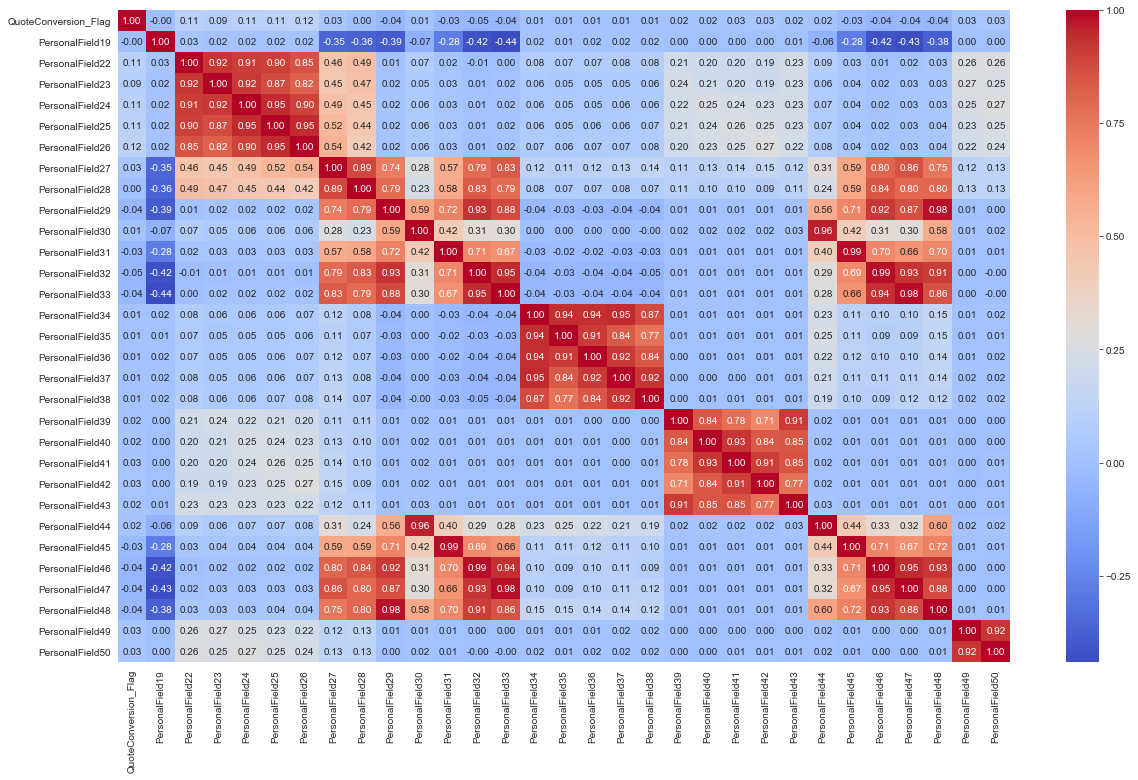

Plot Number:  4


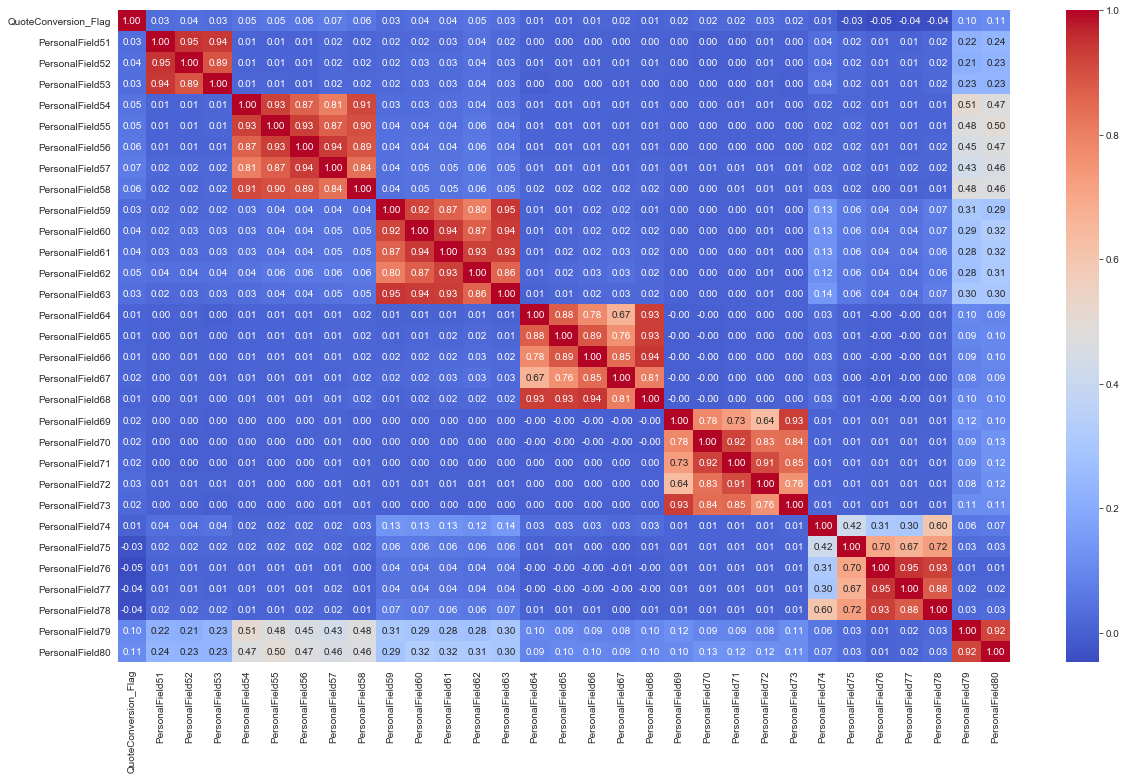

Plot Number:  5


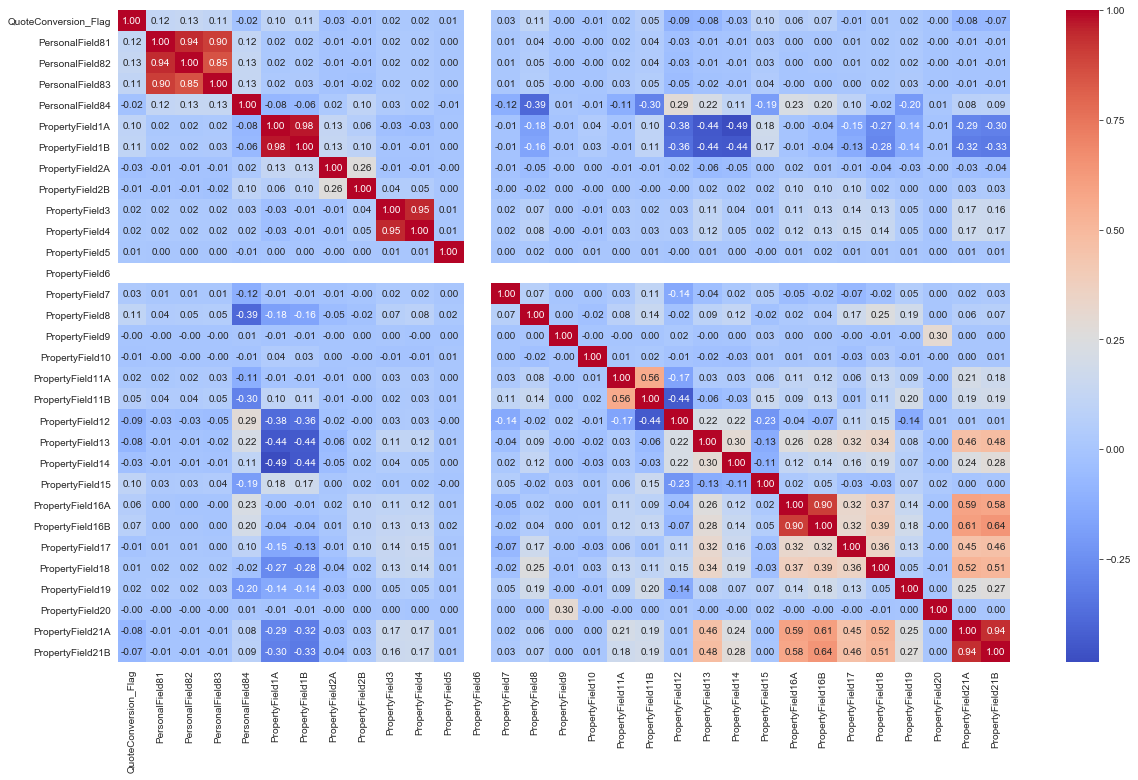

Plot Number:  6


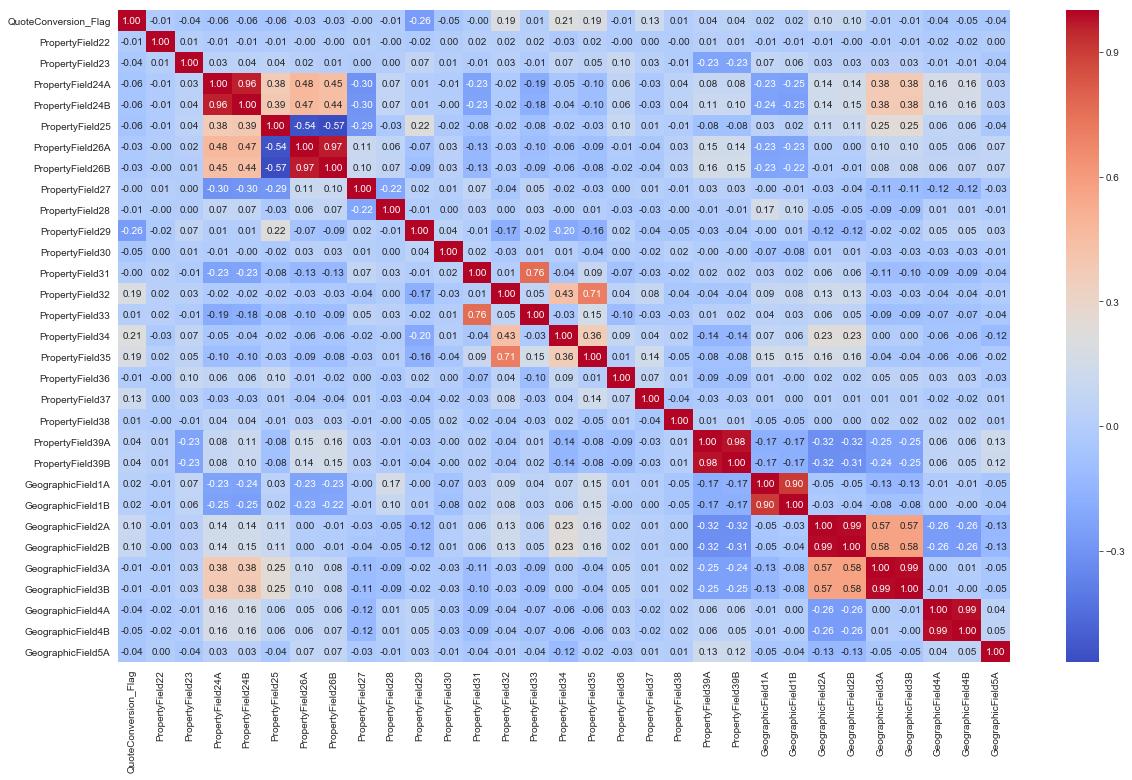

Plot Number:  7


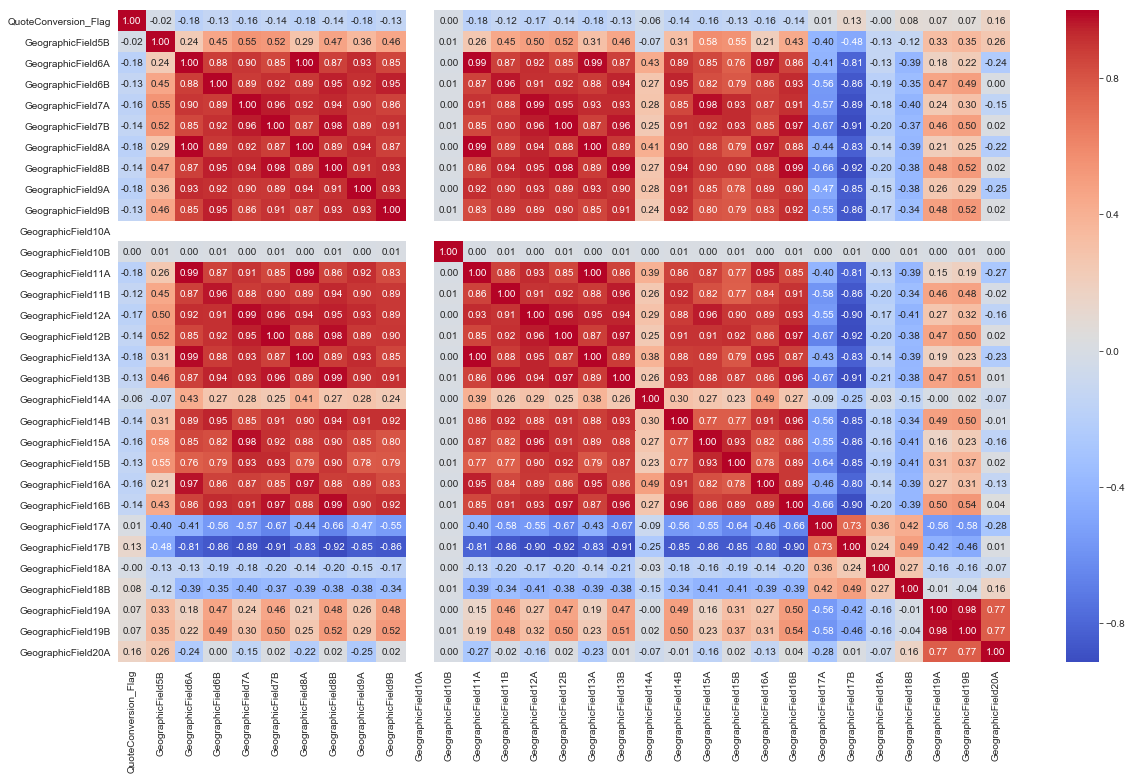

Plot Number:  8


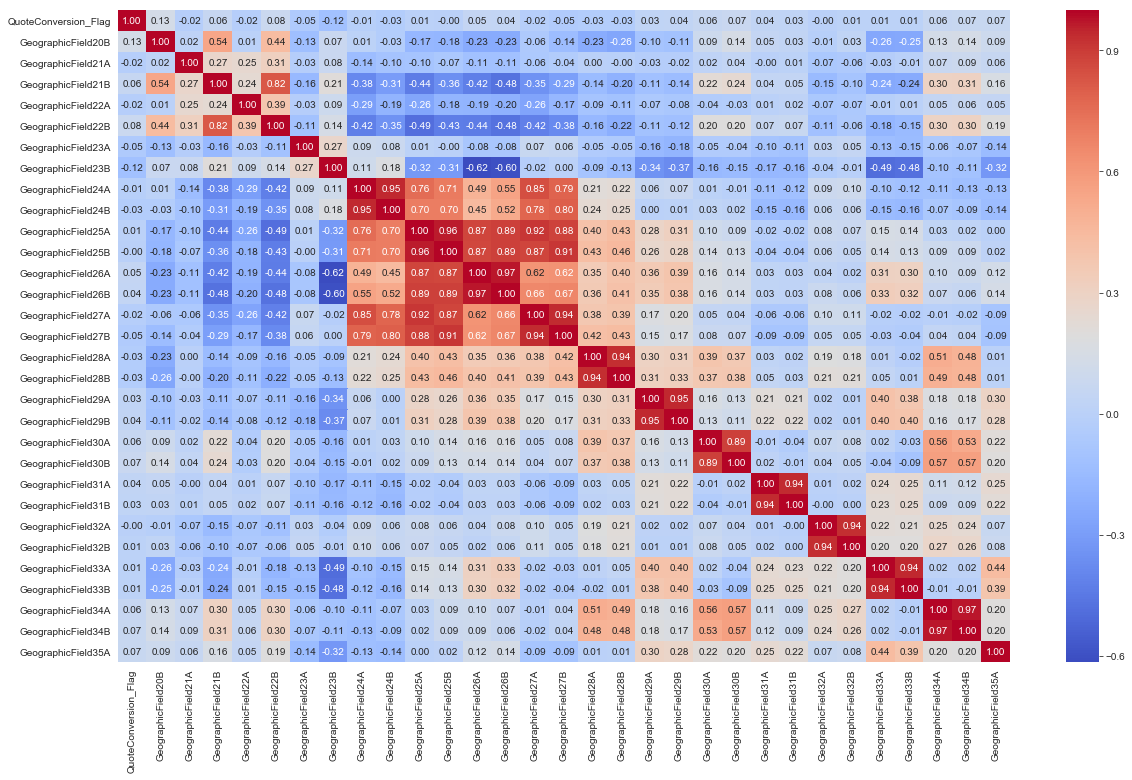

Plot Number:  9


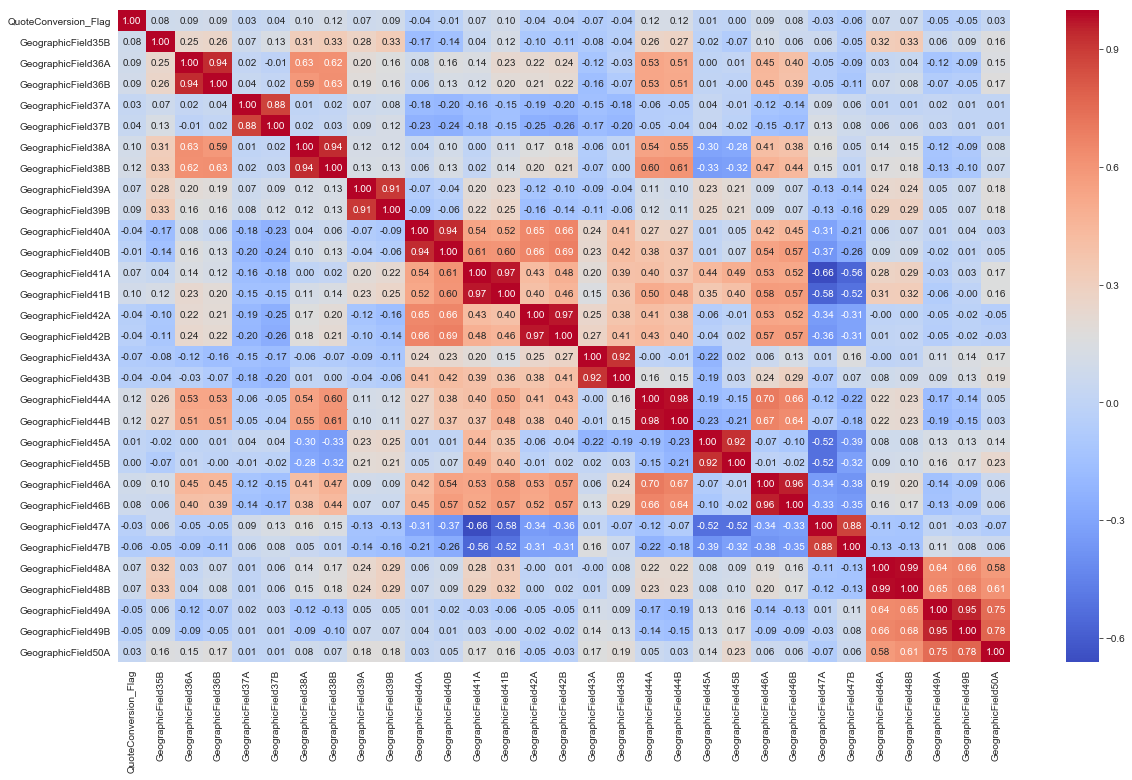

Plot Number:  10


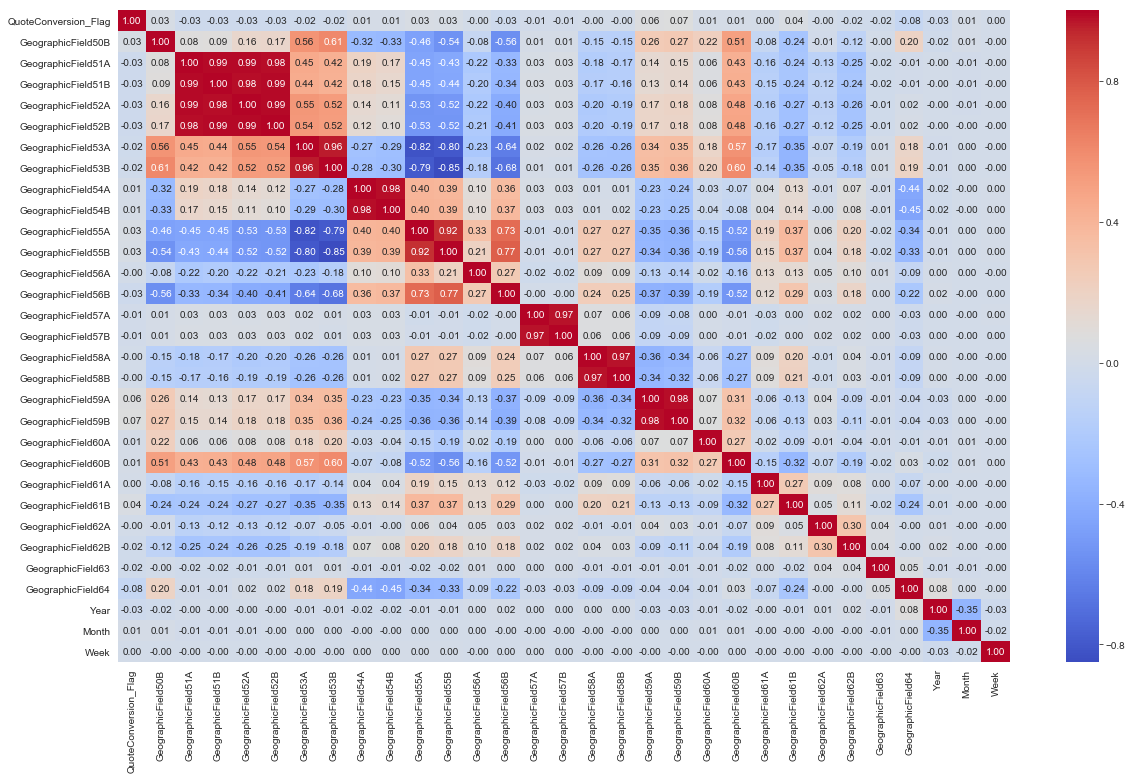

In [77]:
counter=0
plt_cnt=0
for columns in X_train:
    if counter == 0:
        df_heat= pd.DataFrame(homesite_df["QuoteConversion_Flag"])
        plt_cnt=plt_cnt+1
    if counter<30:
        counter=counter+1
        df_heat[columns]= + homesite_df[columns]
    if counter==30:
        print("Plot Number: " , plt_cnt)
        plt.figure(figsize=(20,12))
        sns.heatmap(data=df_heat.iloc[:,:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
        plt.show()
        counter=0
        df_heat=df_heat.iloc[0:0]

### Trying Forward Selection

In [ ]:
from statsmodels.formula.api import ols
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,' + '.join(selected + [candidate]))
            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print("{:.2f}".format(best_new_score),'            | ', best_candidate)
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = ols(formula, data).fit()
    
    return model

In [ ]:
features = homesite_df
# target = homesite_df["QuoteConversion_Flag"]

print('The Best predictors for our model:')
print('-------------------------------------------')
print('R-Squared Value  |  Predictor Name ')
print('-------------------------------------------')

# model = forward_selected(features, 'QuoteConversion_Flag')

print('-------------------------------------------')
print()
print ('R-Squared Value: ')
print (round(model.rsquared_adj,2))

### H2O 

In [78]:
pct_memory=0.95
virtual_memory=psutil.virtual_memory()
print("Virtual Memory Size: ",virtual_memory)
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print("Minimum Memory Size: ",min_mem_size)

Virtual Memory Size:  svmem(total=16902189056, available=7457271808, percent=55.9, used=9444917248, free=7457271808)
Minimum Memory Size:  7


In [79]:
# Connect to a cluster
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:48057..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\kaila\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kaila\AppData\Local\Temp\tmpj6mbxau1
  JVM stdout: C:\Users\kaila\AppData\Local\Temp\tmpj6mbxau1\h2o_Kailash_started_from_python.out
  JVM stderr: C:\Users\kaila\AppData\Local\Temp\tmpj6mbxau1\h2o_Kailash_started_from_python.err
  Server is running at http://127.0.0.1:48057
Connecting to H2O server at http://127.0.0.1:48057... successful.


--------------------------  -------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.1.3
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_Kailash_6gf93q
H2O cluster total nodes:    1
H2O cluster free memory:    6.708 Gb
H2O cluster total cores:    12
H2O cluster allowed cores:  12
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:48057
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Algos, AutoML, Core V3, Core V4
Python version:             3.7.1 final
--------------------------  -------------------------------

In [265]:
H2O_train = h2o.import_file("train.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [266]:
predictors=[x for x in H2O_train.columns if x not in ['QuoteConversion_Flag']]
Target='QuoteConversion_Flag'

In [267]:
# For binary classification, response should be a factor
H2O_train[Target] = H2O_train[Target].asfactor()

In [268]:
aml = H2OAutoML(max_runtime_secs=1800, seed=27)

In [269]:
# os.getcwd()
# os.chdir('../logs')
# logs_path = os.getcwd()
# logfile = 'logs.txt'

In [270]:
model_start_time = time.time()
aml.train(x=predictors, y=Target, training_frame=H2O_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [271]:
meta_data={}
meta_data['model_execution_time'] = {"classification":(time.time() - model_start_time)}
meta_data

{'model_execution_time': {'classification': 336.17096185684204}}

In [272]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id auc logloss mean_per_class_error rmse mse 
 
 
 DRF_1_AutoML_20190401_152753 0.952791 0.228068 0.147079 0.259742 0.0674658

In [276]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()
model_set=aml_leaderboard_df['model_id']
mod_best1=h2o.get_model(model_set[0])

In [277]:
print(mod_best1.auc())

0.9466533669998652


In [278]:
print(mod_best1.algo)

drf


In [279]:
pred11=mod_best1.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [66]:
print(mod_best1.model_id)

StackedEnsemble_BestOfFamily_AutoML_20190330_184521


In [67]:
print(mod_best1.gini)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190330_184521
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.023529725333647795
RMSE: 0.15339401987576892
LogLoss: 0.09413633210497654
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251675.34365208313
Residual deviance: 49092.6620107379
AIC: 49098.6620107379
AUC: 0.994161863879421
pr_auc: 0.9653799432192546
Gini: 0.9883237277588419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45899150203041317: 


0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      209007  2852   0.0135   (2852.0/211859.0)
1      4494    44400  0.0919   (4494.0/48894.0)
Total  213501  47252  0.0282   (7346.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458992     0.923595  186
max f2                       0.293559     0.929905  235
max f0point5                 0.62694      0.951255  140
max accuracy                 0.499448     0.971916  175
max precision                0.995545     1         0
max recall                   0.0222225    1         375
max specificity              0.995545     1         0
max absolute_mcc             0.472877     0.906563  182
max min_per_class_accuracy   0.254614     0.955928  249
max mean_per_class_accuracy  0.293559     0.956766  235

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 19.38 %



group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100018                   0.993305           5.33303      5.33303            1                0.994564    1                           0.994564            0.0533399       0.0533399                  433.303   433.303
    2        0.0200036                   0.991069           5.33303      5.33303            1                0.992179    1                           0.993371            0.0533399       0.10668                    433.303   433.303
    3        0.0300016                   0.988696           5.33303      5.33303            1                0.989919    1                           0.992221            0.0533194       0.159999                   433.303   433.303
    4        0.0400034                   0.985859           5.33303      5.33303            1                0.987365    1                           0.991007            0.0533399       0.213339                   433.303   433.303
    5        0.0500013                   0.98171            5.33303      5.33303            1                0.983964    1                           0.989598            0.0533194       0.266658                   433.303   433.303
    6        0.100003                    0.916085           5.33262      5.33282            0.999923         0.955113    0.999962                    0.972356            0.266638        0.533297                   433.262   433.282
    7        0.15                        0.702321           5.22994      5.29853            0.98067          0.829467    0.993532                    0.924728            0.261484        0.794781                   422.994   429.853
    8        0.200002                    0.329752           2.93607      4.7079             0.550545         0.509799    0.882783                    0.820994            0.146807        0.941588                   193.607   370.79
    9        0.3                         0.0673996          0.531769     3.31588            0.0997124        0.160091    0.621763                    0.600696            0.0531763       0.994764                   -46.8231  231.588
    10       0.399999                    0.0327234          0.0496999    2.49934            0.00931927       0.0451893   0.468653                    0.461821            0.00496993      0.999734                   -95.03    149.934
    11       0.500002                    0.0218179          0.00245422   1.99995            0.000460193      0.0267929   0.375012                    0.374813            0.000245429     0.99998                    -99.7546  99.9951
    12       0.600001                    0.0151063          0.000204526  1.66666            3.83509e-05      0.0180615   0.312518                    0.315355            2.04524e-05     1                          -99.9795  66.6665
    13       0.700003                    0.0128628          0            1.42856            0                0.0137098   0.267871                    0.272262            0               1                          -100      42.8564
    14       0.799998                    0.0116048          0            1.25               0                0.0119828   0.234389                    0.239729            0               1                          -100      25.0002
    15       0.908258                    0.0103691          0            1.10101            0                0.010887    0.206451                    0.212452            0               1                          -100      10.1009
    16       1                           0.00889248         0            1   



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.06202886491083244
RMSE: 0.24905594735085618
LogLoss: 0.20535468534235984
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251676.98613841744
Residual deviance: 107093.70053415271
AIC: 107099.70053415271
AUC: 0.9534669991223957
pr_auc: 0.8505692867574783
Gini: 0.9069339982447915
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4140755712280357: 


0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      200578  11281  0.0532   (11281.0/211859.0)
1      12157   36737  0.2486   (12157.0/48894.0)
Total  212735  48018  0.0899   (23438.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414076     0.758152  198
max f2                       0.120692     0.814344  309
max f0point5                 0.718282     0.815426  105
max accuracy                 0.552891     0.913516  157
max precision                0.994707     1         0
max recall                   0.00933732   1         398
max specificity              0.994707     1         0
max absolute_mcc             0.429436     0.703025  193
max min_per_class_accuracy   0.16129      0.877442  289
max mean_per_class_accuracy  0.144956     0.878199  296

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.75 %



group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100018                   0.990747           5.33303      5.33303            1                0.992915    1                           0.992915            0.0533399       0.0533399                  433.303   433.303
    2        0.0200036                   0.987168           5.32485      5.32894            0.998466         0.988944    0.999233                    0.99093             0.0532581       0.106598                   432.485   432.894
    3        0.0300016                   0.983015           5.32689      5.32825            0.998849         0.985143    0.999105                    0.989001            0.0532581       0.159856                   432.689   432.825
    4        0.0400034                   0.977169           5.32894      5.32843            0.999233         0.98024     0.999137                    0.986811            0.053299        0.213155                   432.894   432.843
    5        0.0500013                   0.967496           5.31052      5.32485            0.995781         0.972815    0.998466                    0.984012            0.0530944       0.266249                   431.052   432.485
    6        0.100003                    0.797996           4.79432      5.05959            0.898988         0.89678     0.948727                    0.940396            0.239723        0.505972                   379.432   405.959
    7        0.15                        0.559412           3.26396      4.46107            0.612027         0.677971    0.836499                    0.852926            0.16319         0.669162                   226.396   346.107
    8        0.200002                    0.350646           2.27097      3.91354            0.425832         0.451829    0.733831                    0.75265             0.113552        0.782714                   127.097   291.354
    9        0.3                         0.100437           1.2877       3.03827            0.241457         0.204344    0.569708                    0.569884            0.128768        0.911482                   28.7698   203.827
    10       0.399999                    0.0436115          0.516634     2.40787            0.0968744        0.0644668   0.451501                    0.443531            0.0516628       0.963145                   -48.3366  140.787
    11       0.500002                    0.0268101          0.218835     1.97005            0.0410339        0.0342538   0.369406                    0.361673            0.0218841       0.985029                   -78.1165  97.005
    12       0.600001                    0.0168629          0.108194     1.65974            0.0202876        0.0213787   0.31122                     0.304958            0.0108193       0.995848                   -89.1806  65.9745
    13       0.7                         0.0125453          0.0304744    1.42699            0.00571429       0.0143137   0.267577                    0.263438            0.00304741      0.998896                   -96.9526  42.6994
    14       0.799998                    0.0108502          0.00736295   1.24954            0.00138063       0.0115294   0.234303                    0.23195             0.000736287     0.999632                   -99.2637  24.9542
    15       0.899997                    0.00970572         0.00286337   1.11102            0.000536913      0.0102798   0.208329                    0.20732             0.000286334     0.999918                   -99.7137  11.1024
    16       1                           0.00888703         0.000818074  1   


<bound method ModelBase.gini of >


#### 2nd Iteration

In [ ]:
aml2 = H2OAutoML(max_runtime_secs=3600, seed=27)

In [69]:
model_start_time = time.time()
aml2.train(x=predictors, y=Target, training_frame=H2O_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [70]:
meta_data={}
meta_data['model_execution_time'] = {"classification":(time.time() - model_start_time)}
meta_data

{'model_execution_time': {'classification': 607.8722033500671}}

In [71]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

model_id auc logloss mean_per_class_error rmse mse 
 
 
 StackedEnsemble_BestOfFamily_AutoML_20190330_184521 0.953467 0.205355 0.150944 0.249056 0.0620289 
 StackedEnsemble_AllModels_AutoML_20190330_184521 0.953467 0.205355 0.150944 0.249056 0.0620289 
 DRF_1_AutoML_20190330_184521 0.952699 0.228044 0.151529 0.259755 0.0674725 
 XRT_1_AutoML_20190330_184521 0.945866 0.259764 0.163655 0.274931 0.0755872

In [73]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()
model_set1=aml_leaderboard_df['model_id']
mod_best1=h2o.get_model(model_set1[0])

In [74]:
print(mod_best1.auc())

0.994161863879421


In [75]:
print(mod_best1.algo)

stackedensemble


In [76]:
print(mod_best1.model_id)

StackedEnsemble_BestOfFamily_AutoML_20190330_184521


In [77]:
print(np.array(mod_best1.params))

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_BestOfFamily_AutoML_20190330_184521', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190330_184521'}}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'automl_training_py_1_sid_a71a', 'type': 'Key<Frame>', 'URL': '/3/Frames/automl_training_py_1_sid_a71a'}}, 'response_column': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'QuoteConversion_Flag', 'is_member_of_frames': None}}, 'validation_frame': {'default': None, 'actual': None}, 'base_models': {'default': [], 'actual': [{'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'DRF_1_AutoML_20190330_184521', 'type': 'Ke

In [78]:
print(mod_best1.gini)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190330_184521
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.023529725333647795
RMSE: 0.15339401987576892
LogLoss: 0.09413633210497654
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251675.34365208313
Residual deviance: 49092.6620107379
AIC: 49098.6620107379
AUC: 0.994161863879421
pr_auc: 0.9653799432192546
Gini: 0.9883237277588419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45899150203041317: 


0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      209007  2852   0.0135   (2852.0/211859.0)
1      4494    44400  0.0919   (4494.0/48894.0)
Total  213501  47252  0.0282   (7346.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458992     0.923595  186
max f2                       0.293559     0.929905  235
max f0point5                 0.62694      0.951255  140
max accuracy                 0.499448     0.971916  175
max precision                0.995545     1         0
max recall                   0.0222225    1         375
max specificity              0.995545     1         0
max absolute_mcc             0.472877     0.906563  182
max min_per_class_accuracy   0.254614     0.955928  249
max mean_per_class_accuracy  0.293559     0.956766  235

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 19.38 %



group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100018                   0.993305           5.33303      5.33303            1                0.994564    1                           0.994564            0.0533399       0.0533399                  433.303   433.303
    2        0.0200036                   0.991069           5.33303      5.33303            1                0.992179    1                           0.993371            0.0533399       0.10668                    433.303   433.303
    3        0.0300016                   0.988696           5.33303      5.33303            1                0.989919    1                           0.992221            0.0533194       0.159999                   433.303   433.303
    4        0.0400034                   0.985859           5.33303      5.33303            1                0.987365    1                           0.991007            0.0533399       0.213339                   433.303   433.303
    5        0.0500013                   0.98171            5.33303      5.33303            1                0.983964    1                           0.989598            0.0533194       0.266658                   433.303   433.303
    6        0.100003                    0.916085           5.33262      5.33282            0.999923         0.955113    0.999962                    0.972356            0.266638        0.533297                   433.262   433.282
    7        0.15                        0.702321           5.22994      5.29853            0.98067          0.829467    0.993532                    0.924728            0.261484        0.794781                   422.994   429.853
    8        0.200002                    0.329752           2.93607      4.7079             0.550545         0.509799    0.882783                    0.820994            0.146807        0.941588                   193.607   370.79
    9        0.3                         0.0673996          0.531769     3.31588            0.0997124        0.160091    0.621763                    0.600696            0.0531763       0.994764                   -46.8231  231.588
    10       0.399999                    0.0327234          0.0496999    2.49934            0.00931927       0.0451893   0.468653                    0.461821            0.00496993      0.999734                   -95.03    149.934
    11       0.500002                    0.0218179          0.00245422   1.99995            0.000460193      0.0267929   0.375012                    0.374813            0.000245429     0.99998                    -99.7546  99.9951
    12       0.600001                    0.0151063          0.000204526  1.66666            3.83509e-05      0.0180615   0.312518                    0.315355            2.04524e-05     1                          -99.9795  66.6665
    13       0.700003                    0.0128628          0            1.42856            0                0.0137098   0.267871                    0.272262            0               1                          -100      42.8564
    14       0.799998                    0.0116048          0            1.25               0                0.0119828   0.234389                    0.239729            0               1                          -100      25.0002
    15       0.908258                    0.0103691          0            1.10101            0                0.010887    0.206451                    0.212452            0               1                          -100      10.1009
    16       1                           0.00889248         0            1   



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.06202886491083244
RMSE: 0.24905594735085618
LogLoss: 0.20535468534235984
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251676.98613841744
Residual deviance: 107093.70053415271
AIC: 107099.70053415271
AUC: 0.9534669991223957
pr_auc: 0.8505692867574783
Gini: 0.9069339982447915
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4140755712280357: 


0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      200578  11281  0.0532   (11281.0/211859.0)
1      12157   36737  0.2486   (12157.0/48894.0)
Total  212735  48018  0.0899   (23438.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414076     0.758152  198
max f2                       0.120692     0.814344  309
max f0point5                 0.718282     0.815426  105
max accuracy                 0.552891     0.913516  157
max precision                0.994707     1         0
max recall                   0.00933732   1         398
max specificity              0.994707     1         0
max absolute_mcc             0.429436     0.703025  193
max min_per_class_accuracy   0.16129      0.877442  289
max mean_per_class_accuracy  0.144956     0.878199  296

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.75 %



group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100018                   0.990747           5.33303      5.33303            1                0.992915    1                           0.992915            0.0533399       0.0533399                  433.303   433.303
    2        0.0200036                   0.987168           5.32485      5.32894            0.998466         0.988944    0.999233                    0.99093             0.0532581       0.106598                   432.485   432.894
    3        0.0300016                   0.983015           5.32689      5.32825            0.998849         0.985143    0.999105                    0.989001            0.0532581       0.159856                   432.689   432.825
    4        0.0400034                   0.977169           5.32894      5.32843            0.999233         0.98024     0.999137                    0.986811            0.053299        0.213155                   432.894   432.843
    5        0.0500013                   0.967496           5.31052      5.32485            0.995781         0.972815    0.998466                    0.984012            0.0530944       0.266249                   431.052   432.485
    6        0.100003                    0.797996           4.79432      5.05959            0.898988         0.89678     0.948727                    0.940396            0.239723        0.505972                   379.432   405.959
    7        0.15                        0.559412           3.26396      4.46107            0.612027         0.677971    0.836499                    0.852926            0.16319         0.669162                   226.396   346.107
    8        0.200002                    0.350646           2.27097      3.91354            0.425832         0.451829    0.733831                    0.75265             0.113552        0.782714                   127.097   291.354
    9        0.3                         0.100437           1.2877       3.03827            0.241457         0.204344    0.569708                    0.569884            0.128768        0.911482                   28.7698   203.827
    10       0.399999                    0.0436115          0.516634     2.40787            0.0968744        0.0644668   0.451501                    0.443531            0.0516628       0.963145                   -48.3366  140.787
    11       0.500002                    0.0268101          0.218835     1.97005            0.0410339        0.0342538   0.369406                    0.361673            0.0218841       0.985029                   -78.1165  97.005
    12       0.600001                    0.0168629          0.108194     1.65974            0.0202876        0.0213787   0.31122                     0.304958            0.0108193       0.995848                   -89.1806  65.9745
    13       0.7                         0.0125453          0.0304744    1.42699            0.00571429       0.0143137   0.267577                    0.263438            0.00304741      0.998896                   -96.9526  42.6994
    14       0.799998                    0.0108502          0.00736295   1.24954            0.00138063       0.0115294   0.234303                    0.23195             0.000736287     0.999632                   -99.2637  24.9542
    15       0.899997                    0.00970572         0.00286337   1.11102            0.000536913      0.0102798   0.208329                    0.20732             0.000286334     0.999918                   -99.7137  11.1024
    16       1                           0.00888703         0.000818074  1   


<bound method ModelBase.gini of >


In [79]:
aml_leaderboard_df

model_id       auc   logloss  \
0  StackedEnsemble_BestOfFamily_AutoML_20190330_1...  0.953467  0.205355   
1   StackedEnsemble_AllModels_AutoML_20190330_184521  0.953467  0.205355   
2                       DRF_1_AutoML_20190330_184521  0.952699  0.228044   
3                       XRT_1_AutoML_20190330_184521  0.945866  0.259764   

   mean_per_class_error      rmse       mse  
0              0.150944  0.249056  0.062029  
1              0.150944  0.249056  0.062029  
2              0.151529  0.259755  0.067472  
3              0.163655  0.274931  0.075587

#### StackedEnsembleEstimator 

In [100]:
X_train = homesite_df.drop("QuoteConversion_Flag",axis=1)
Y_train = homesite_df["QuoteConversion_Flag"]
X_test  = test_df.drop("QuoteNumber",axis=1).copy()

In [127]:
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train, Y_train, random_state=20)

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
classifiers = [GradientBoostingClassifier()]

In [129]:
print(classifiers)

[GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)]


In [130]:
for classifier in classifiers:
    homesite_log = classifier 
    homesite_log.fit(X_train_sub, y_train_sub)

    show_validation = True

    if (show_validation == True):
        y_probs = homesite_log.predict_proba(X_validation_sub)
        y_pred = homesite_log.predict(X_validation_sub)
        print(type(classifier))
        print("accuracy_score1:", accuracy_score(y_validation_sub, y_pred))
        print("log_loss1:", log_loss(y_validation_sub, y_probs))
    
    elif (show_validation == False):
        y_probs = homesite_log.predict_proba(X_train_sub)
        y_pred = homesite_log.predict(X_train_sub)
        print(type(classifier))
        print("accuracy_score:", accuracy_score(y_train_sub, y_pred))
        print("log_loss:", log_loss(y_train_sub, y_probs))

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
accuracy_score1: 1.0
log_loss1: 0.00023937766341358574


In [135]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['QuoteConversion_Flag'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['QuoteConversion_Flag'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['QuoteConversion_Flag'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['QuoteConversion_Flag'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9232
AUC Score (Train): 0.959501
CV Score : Mean - 0.9592153 | Std - 0.0009584875 | Min - 0.9575986 | Max - 0.9605393


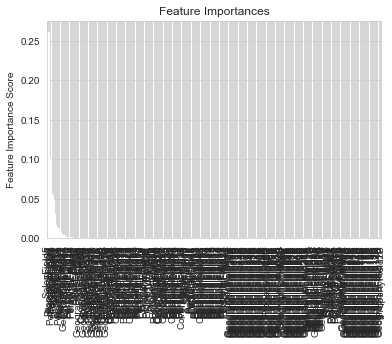

In [136]:
#Choose all predictors except target & IDcols
target='QuoteConversion_Flag'
predictors = [x for x in homesite_df.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, homesite_df, predictors)

### Stack Ensembled USing H2O

In [251]:
train = h2o.import_file("train.csv")
test = h2o.import_file("test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [252]:
# Identify predictors and response
x = train.columns
y = "QuoteConversion_Flag"
x.remove(y)

In [253]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

In [254]:
# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

In [255]:
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [256]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [258]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [259]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(train)

In [260]:
perf_stack_test


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.03207665143829268
RMSE: 0.17909955733695346
LogLoss: 0.11857754197186664
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251675.34365208313
Residual deviance: 61838.899603580285
AIC: 61844.899603580285
AUC: 0.9880931949962739
pr_auc: 0.943292977432894
Gini: 0.9761863899925478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45185876543051295: 


0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      208714  3145   0.0148   (3145.0/211859.0)
1      6779    42115  0.1386   (6779.0/48894.0)
Total  215493  45260  0.0381   (9924.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451859     0.894598  187
max f2                       0.279238     0.892924  246
max f0point5                 0.605579     0.935273  139
max accuracy                 0.481723     0.962079  177
max precision                0.998013     1         0
max recall                   0.0224015    1         376
max specificity              0.998013     1         0
max absolute_mcc             0.456584     0.872554  185
max min_per_class_accuracy   0.211209     0.931355  271
max mean_per_class_accuracy  0.280627     0.933426  245

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.84 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100018                   0.996642           5.33303     5.33303            1                0.997413   1                           0.997413            0.0533399       0.0533399                  433.303   433.303
    2        0.0200036                   0.995229           5.33303     5.33303            1                0.995945   1                           0.996679            0.0533399       0.10668                    433.303   433.303
    3        0.0300016                   0.993867           5.33303     5.33303            1                0.994555   1                           0.995971            0.0533194       0.159999                   433.303   433.303
    4        0.0400034                   0.99209            5.33303     5.33303            1                0.993043   1                           0.995239            0.0533399       0.213339                   433.303   433.303
    5        0.0500013                   0.988864           5.33303     5.33303            1                0.990656   1                           0.994323            0.0533194       0.266658                   433.303   433.303
    6        0.100003                    0.876624           5.32198     5.3275             0.997929         0.947564   0.998965                    0.970943            0.266106        0.532765                   432.198   432.75
    7        0.15                        0.602907           5.05445     5.23649            0.947764         0.754261   0.981899                    0.89872             0.25271         0.785475                   405.445   423.649
    8        0.200002                    0.320288           2.35524     4.51616            0.441632         0.449625   0.846829                    0.786444            0.117765        0.90324                    135.524   351.616
    9        0.3                         0.0740212          0.774337    3.2689             0.145197         0.171654   0.612955                    0.581516            0.0774328       0.980672                   -22.5663  226.89
    10       0.399999                    0.0310565          0.184278    2.49776            0.0345542        0.0457868  0.468356                    0.447585            0.0184276       0.9991                     -81.5722  149.776
    11       0.500002                    0.0223566          0.00899882  1.99999            0.00168738       0.0263155  0.37502                     0.363329            0.000899906     1                          -99.1001  99.9992
    12       0.600008                    0.0159756          0           1.66664            0                0.0189373  0.312514                    0.305928            0               1                          -100      66.6643
    13       0.700003                    0.0130421          0           1.42856            0                0.0144712  0.267871                    0.264293            0               1                          -100      42.8564
    14       0.800002                    0.0116581          0           1.25               0                0.0122465  0.234388                    0.232788            0               1                          -100      24.9996
    15       0.92231                     0.011064           0           1.08423            0                0.0112017  0.203306                    0.203403            0               1                          -100      8.42346
    16       1                           0.00985478         0           1                  0                0.01

In [261]:
# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(train)
perf_rf_test = my_rf.model_performance(train)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

Best Base-learner Test AUC:  0.9950478269366968
Ensemble Test AUC:  0.9880931949962739


In [262]:
pred = ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [281]:
pred.head(100)

predict p0 p1 
 
 
 0 0.986626 0.0133737 
 0 0.977378 0.0226215 
 0 0.978729 0.0212715 
 0 0.985654 0.0143464 
 0 0.910024 0.0899762 
 0 0.976472 0.0235278 
 0 0.988904 0.0110959 
 0 0.973513 0.026487 
 0 0.988936 0.011064 
 0 0.986412 0.0135879 
 0 0.978132 0.0218679 
 0 0.751206 0.248794 
 0 0.988426 0.0115736 
 0 0.925089 0.0749114 
 0 0.931767 0.0682329 
 0 0.965539 0.0344611 
 0 0.989342 0.0106577 
 0 0.98901 0.0109902 
 0 0.966392 0.0336085 
 0 0.959851 0.0401494 
 0 0.928491 0.0715088 
 0 0.730863 0.269137 
 0 0.919627 0.0803731 
 0 0.924594 0.0754061 
 1 0.442502 0.557498 
 1 0.50099 0.49901 
 1 0.00346205 0.996538 
 0 0.979556 0.0204444 
 0 0.98883 0.0111697 
 0 0.984798 0.0152024 
 1 0.567028 0.432972 
 0 0.810513 0.189487 
 0 0.988936 0.011064 
 1 0.262688 0.737312 
 0 0.989015 0.0109851 
 0 0.979867 0.0201329 
 1 0.499125 0.500875 
 0 0.79858 0.20142 
 0 0.98126 0.01874 
 1 0.385116 0.614884 
 1 0.197412 0.802588 
 0 0.976706 0.0232941 
 0 0.98325 0.0167501 
 0 0.987762 0.0122383 
 0 0.775789 0.224211 
 0 0.96219 0.0378097 
 0 0.968213 0.0317874 
 0 0.988265 0.0117346 
 1 0.00471177 0.995288 
 0 0.96375 0.0362495 
 0 0.781442 0.218558 
 0 0.940584 0.0594158 
 0 0.979262 0.0207381 
 0 0.976011 0.0239893 
 0 0.988451 0.0115493 
 1 0.5273 0.4727 
 0 0.978821 0.0211789 
 0 0.974682 0.0253183 
 0 0.987031 0.0129691 
 0 0.975478 0.0245223 
 0 0.98883 0.0111704 
 0 0.985294 0.0147064 
 0 0.696149 0.303851 
 0 0.988354 0.0116459 
 0 0.987644 0.0123557 
 0 0.98816 0.0118404 
 0 0.971313 0.0286865 
 0 0.971044 0.0289559 
 1 0.0341412 0.965859 
 0 0.979628 0.0203718 
 0 0.984125 0.0158747 
 0 0.722747 0.277253 
 0 0.988936 0.011064 
 0 0.986027 0.0139732 
 0 0.973432 0.0265682 
 0 0.61796 0.38204 
 0 0.964606 0.0353942 
 0 0.985888 0.0141123 
 0 0.989155 0.0108451 
 0 0.785567 0.214433 
 1 0.278609 0.721391 
 1 0.0018045 0.998195 
 0 0.97225 0.0277502 
 1 0.0461254 0.953875 
 0 0.985899 0.0141012 
 0 0.94134 0.0586602 
 0 0.98453 0.0154697 
 0 0.989453 0.0105467 
 0 0.973485 0.0265146 
 1 0.0231698 0.97683 
 0 0.988069 0.0119307 
 0 0.624367 0.375633 
 0 0.872291 0.127709 
 0 0.986117 0.0138834 
 0 0.958847 0.0411535 
 0 0.990137 0.00986278 
 1 0.424935 0.575065 
 0 0.961738 0.0382615 
 0 0.987646 0.0123543 
 0 0.989497 0.0105031

In [211]:
# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

In [212]:
# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)



gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [213]:
# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)


stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [247]:
perf_stack_test = ensemble.model_performance(train)

In [248]:
perf_stack_test


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.07376720490829587
RMSE: 0.271601187236536
LogLoss: 0.24586752088371994
Null degrees of freedom: 260752
Residual degrees of freedom: 260750
Null deviance: 251675.34365208313
Residual deviance: 128221.38734598526
AIC: 128227.38734598526
AUC: 0.9295700813154306
pr_auc: 0.8072387767999121
Gini: 0.8591401626308612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4054918166364702: 


0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      200093  11766  0.0555   (11766.0/211859.0)
1      16327   32567  0.3339   (16327.0/48894.0)
Total  216420  44333  0.1077   (28093.0/260753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405492     0.69866   175
max f2                       0.12723      0.775433  295
max f0point5                 0.615372     0.804931  111
max accuracy                 0.590066     0.900293  117
max precision                0.989159     1         0
max recall                   0.0192646    1         395
max specificity              0.989159     1         0
max absolute_mcc             0.615372     0.641678  111
max min_per_class_accuracy   0.155275     0.840219  279
max mean_per_class_accuracy  0.12723      0.849175  295

Gains/Lift Table: Avg response rate: 18.75 %, avg score: 18.72 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0201455                   0.98332            5.32897     5.32897            0.999239         0.983849   0.999239                    0.983849            0.107355        0.107355                   432.897   432.897
    2        0.0310984                   0.98062            5.32182     5.32645            0.997899         0.98185    0.998767                    0.983145            0.0582894       0.165644                   432.182   432.645
    3        0.0411999                   0.979355           5.32695     5.32657            0.998861         0.979562   0.99879                     0.982266            0.0538103       0.219454                   432.695   432.657
    4        0.050009                    0.972806           5.30981     5.32362            0.995646         0.974971   0.998236                    0.980981            0.0467747       0.266229                   430.981   432.362
    5        0.113886                    0.609558           4.24599     4.7192             0.79617          0.780347   0.8849                      0.868449            0.271219        0.537448                   324.599   371.92
    6        0.150269                    0.514027           2.31377     4.13679            0.433857         0.569405   0.775694                    0.796044            0.0841821       0.62163                    131.377   313.679
    7        0.215238                    0.290434           1.88408     3.45681            0.353285         0.370399   0.64819                     0.667563            0.122408        0.744038                   88.4078   245.681
    8        0.301005                    0.136937           1.40885     2.87328            0.264175         0.217992   0.53877                     0.539465            0.120833        0.864871                   40.885    187.328
    9        0.406327                    0.0390318          0.532273    2.26648            0.099807         0.0797871  0.424989                    0.420314            0.05606         0.920931                   -46.7727  126.648
    10       0.503618                    0.0366975          0.512092    1.92756            0.0960227        0.0376503  0.361438                    0.346389            0.0498221       0.970753                   -48.7908  92.7557
    11       0.608814                    0.0328297          0.231364    1.63448            0.0433832        0.0348318  0.306482                    0.292556            0.0243384       0.995091                   -76.8636  63.4476
    12       0.703236                    0.0258177          0.0385557   1.42019            0.0072296        0.0288912  0.266302                    0.257154            0.00364053      0.998732                   -96.1444  42.0194
    13       0.799998                    0.0226405          0.00845472  1.24944            0.00158535       0.02455    0.234283                    0.22902             0.000818096     0.99955                    -99.1545  24.944
    14       0.900339                    0.0202703          0.0026498   1.11049            0.000496866      0.0213507  0.208229                    0.205876            0.000265881     0.999816                   -99.735   11.0489
    15       1                           0.0171426          0.00184697  1                  0.000346327      0.0187379  0.187511                    0.187225            0.000184072     1                          -99.8153  0

In [218]:
# # Compare to base learner performance on the test set
# baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
# stack_auc_test = perf_stack_test.auc()
# print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
# print("Ensemble Test AUC:  {0}".format(stack_auc_test))

In [219]:
# Generate predictions on a test set (if neccessary)
pred1 = ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [245]:
pred1

predict p0 p1 
 
 
 0 0.974929 0.0250709 
 0 0.961715 0.0382847 
 0 0.963922 0.0360777 
 0 0.967697 0.0323027 
 0 0.962684 0.0373157 
 0 0.964379 0.0356205 
 0 0.977009 0.0229908 
 0 0.963302 0.0366975 
 0 0.979849 0.0201513 
 0 0.979688 0.0203118

In [246]:
ensemble.auc()

0.9295700813154306